In [135]:
# PART A: PARTICLE TRACKING
from __future__ import division, unicode_literals, print_function # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series # for convenience
import pims
import trackpy as tp

In [136]:
# Optionally, tweak styles.
mpl.rc('figure', figsize=(10, 5))
mpl.rc('image', cmap='gray')

@pims.pipeline
def gray(image):
    return image[:, :, 1] # Take just the green channel


In [137]:
frames = gray(pims.Video('A22.avi'))
print(frames[0])
plt.imshow(frames[0])

            y            x        mass      size       ecc     signal  \
0  194.670732   241.597561   72.119449  2.180848  0.035035   6.156538   
1  194.725490    17.392157   89.709558  2.236068  0.087958   7.036044   
2  194.811912   124.373041  280.562246  2.425698  0.188358  23.746648   
3  194.493827   518.271605   71.239943  2.027588  0.191042   7.036044   
4  194.740741  1243.656085  166.226534  2.281743  0.086318  13.192582   

   raw_mass        ep  frame  
0     124.0  0.011756      0  
1     137.0  0.010640      0  
2     331.0  0.004402      0  
3     121.0  0.012048      0  
4     217.0  0.006716      0  


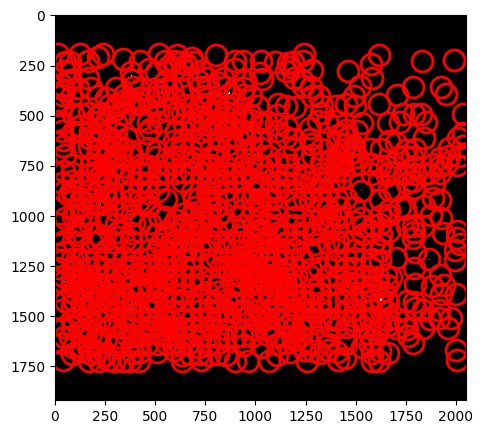

<Axes: >

In [138]:
# STEP 2: LOCATE FEATURES
f = tp.locate(frames[0], 21)
print(f.head()) # See top rows and columns for frame 0
plt.figure()
tp.annotate(f, frames[0])

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

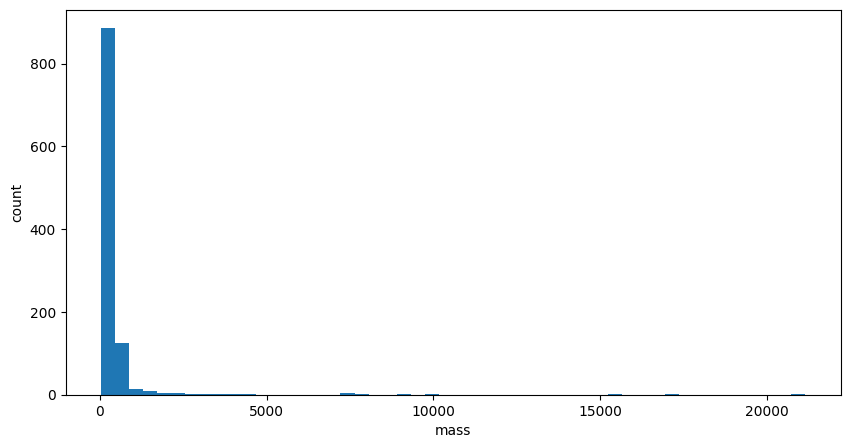

In [139]:
# Diagnostics
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

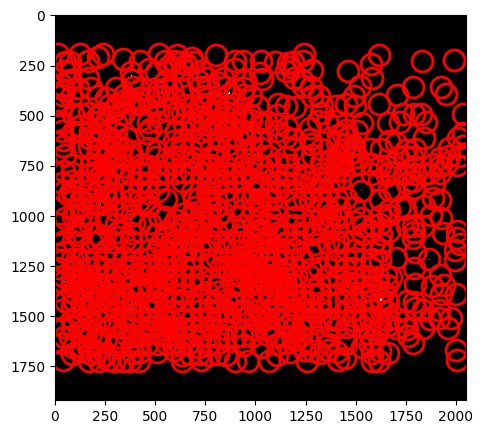

<Axes: >

In [140]:
f = tp.locate(frames[0], 21, minmass=20)
tp.annotate(f, frames[0])

/usr/local/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()
/usr/local/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

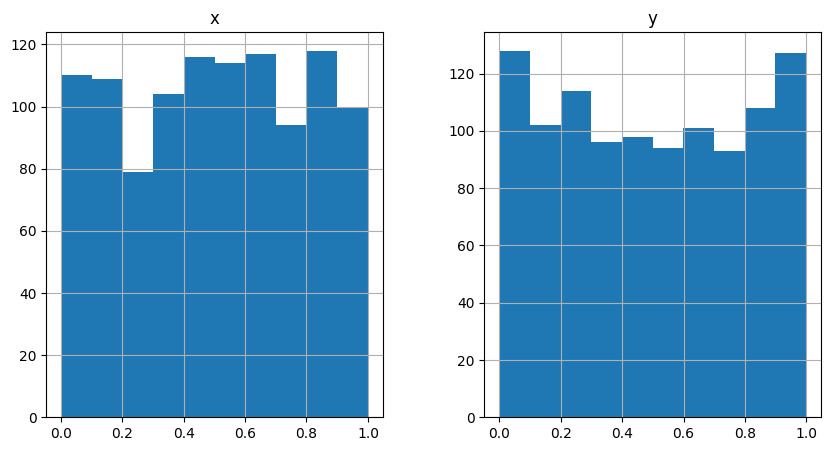

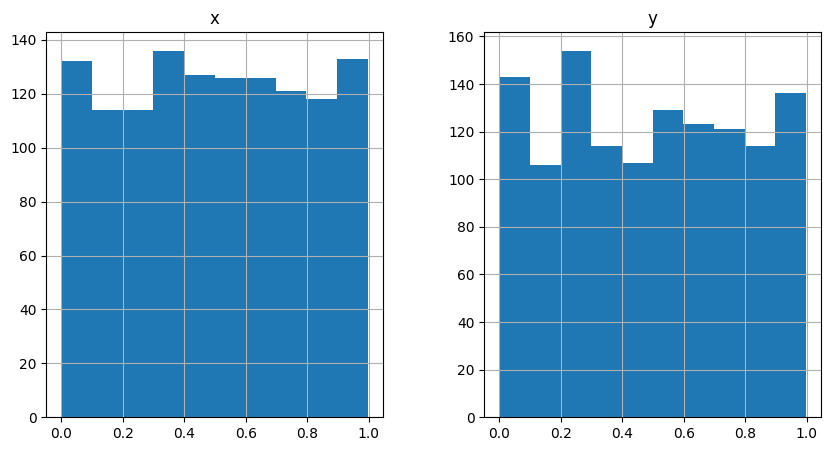

In [141]:
# Subpixel accuracy
tp.subpx_bias(f)
tp.subpx_bias(tp.locate(frames[0], 15, minmass=20))

In [142]:
f = tp.batch(frames[:80], 15, minmass=10, engine='numba',processes=1)

Frame 79: 1389 features


In [143]:
# STEP 3: LINK FEATURES INTO PARTICLE TRAJECTORIES
t = tp.link(f, 8, memory=3)

Frame 79: 1389 trajectories present.


Before: 53089
After: 808


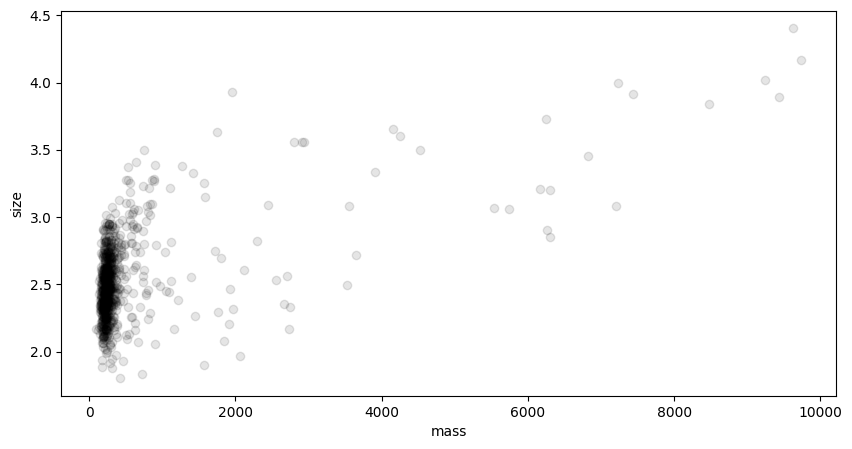

<Axes: xlabel='mass', ylabel='size'>

In [152]:
# Filter spurious trajectories
t1 = tp.filter_stubs(t, 10)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

plt.figure()
tp.mass_size(t1.groupby('particle').mean()) # convenience function -- just plots size vs. mass

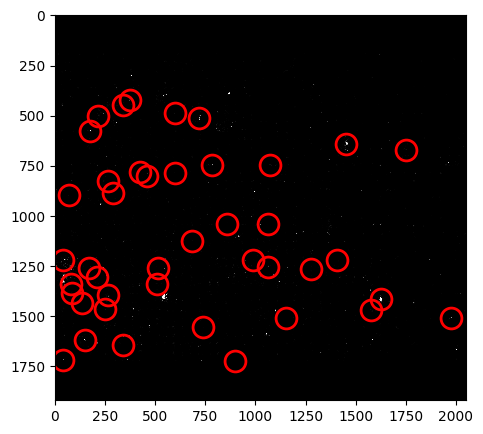

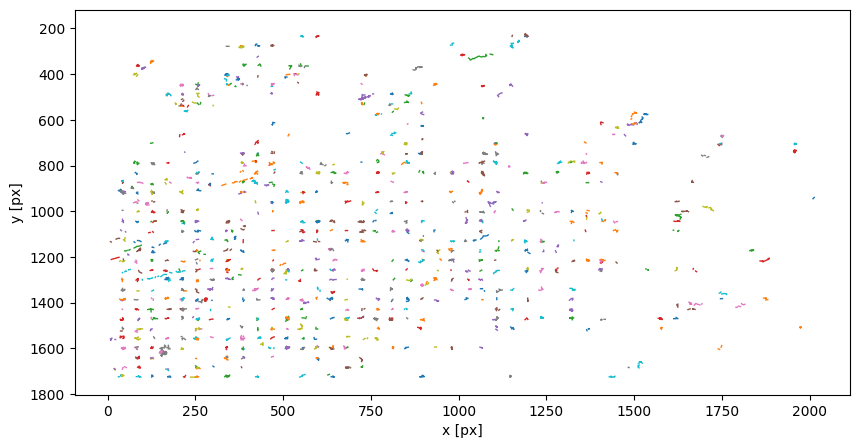

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [153]:
t2 = t1[((t1['mass'] > 3) & (t1['size'] < 20) & (t1['ecc'] < 0.3))]
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0])

plt.figure()
tp.plot_traj(t2)

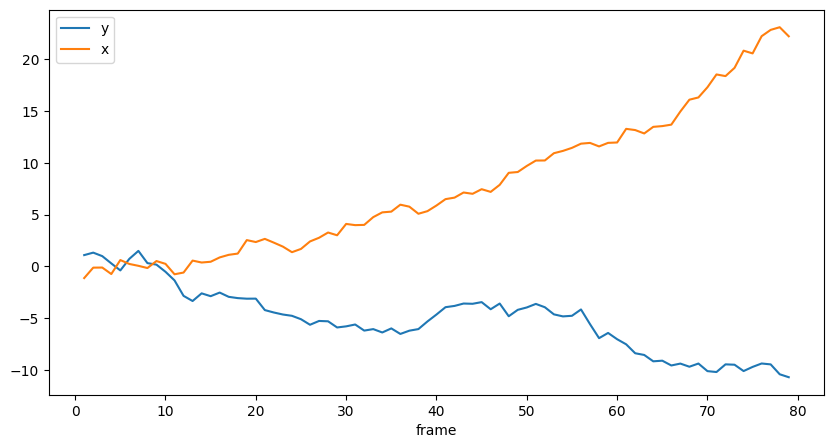

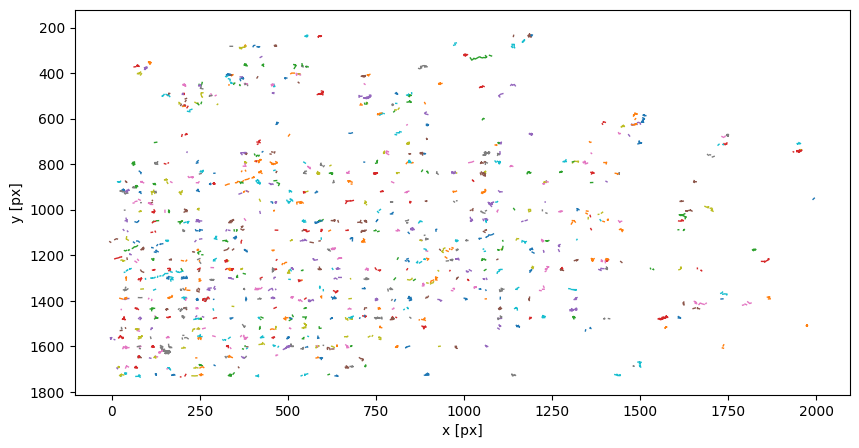

In [154]:
# Remove overall drift
d = tp.compute_drift(t2)
d.plot()
plt.show()

tm = tp.subtract_drift(t2.copy(), d)
ax = tp.plot_traj(tm)
plt.show()

In [155]:
# STEP 4: ANALYZE TRAJECTORIES
tm = tm.reset_index(drop=True)
im = tp.imsd(tm, 0.055, 6.2) # microns per pixel = 0.055, frames per second = 6.2

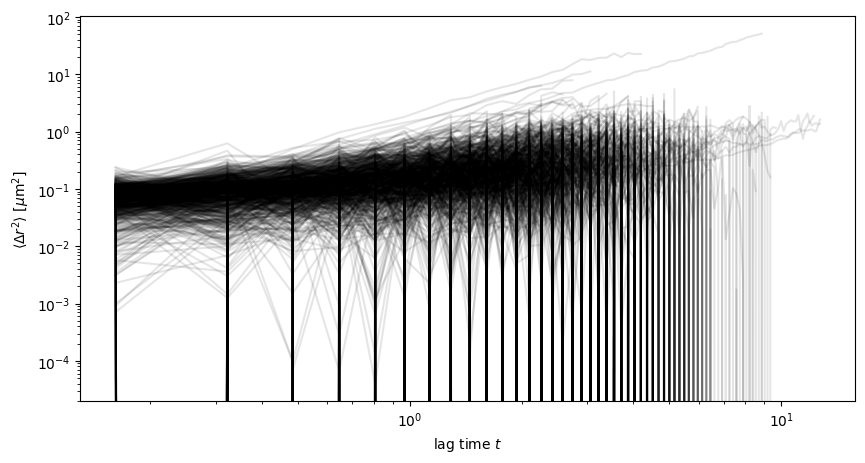

In [156]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1) # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', 
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

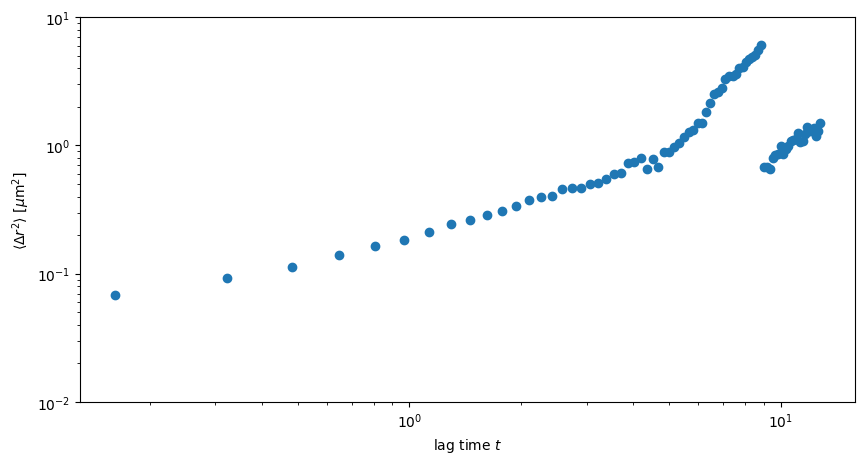

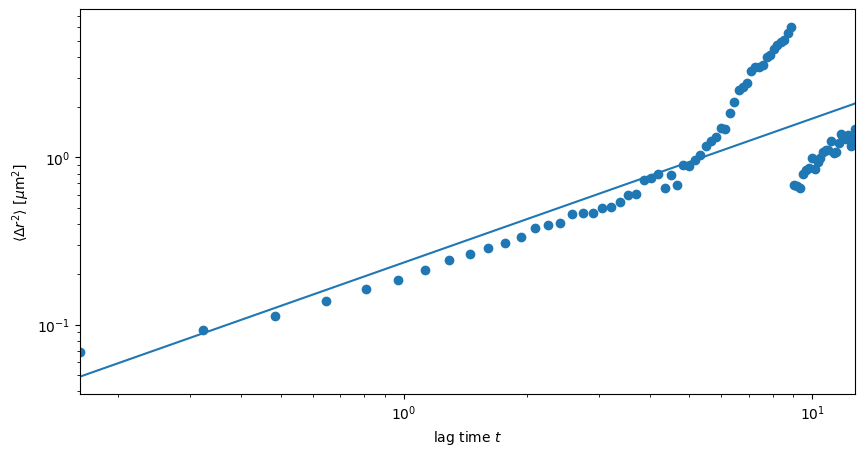

,n,A
msd,0.861102,0.235051


In [157]:
# Ensemble Mean Squared Displacement
em = tp.emsd(tm, 0.055, 6.2) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10))

plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$')
tp.utils.fit_powerlaw(em) # performs linear best fit in log space, plots

54


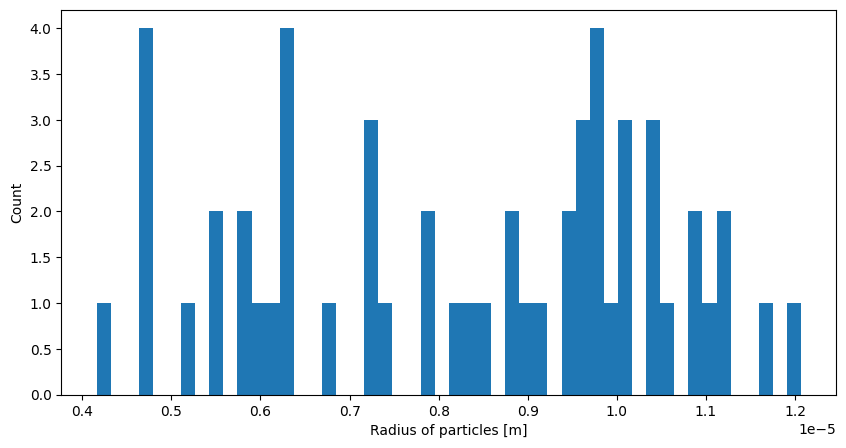

Average radius: 8.30e-06 +- 2.16e-06


In [159]:
# Find the optical radius
find_r = lambda i: (4.11 * 10**-21) / (6 * np.pi * 10**-3 * i)
size_list = t1["size"][0].to_list()
print(len(size_list))
size_list_r = [elem * 0.228 for elem in size_list]
r_optical = []
for i in size_list_r:
    r_optical.append(find_r(i) * 2 * 10**13)

cx = plt.subplot()
cx.hist(r_optical, bins=50)
cx.set(xlabel='Radius of particles [m]', ylabel='Count')
plt.show()

print('Average radius:', '{:.2e}'.format(np.mean(r_optical)), '+-', '{:.2e}'.format(np.std(r_optical)))